<a href="https://colab.research.google.com/github/nmk1406/nmk1406/blob/master/heart_failure_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Heart Failure Prediction**

**Author:** Nguyen Minh Khoa

**Email:** nmk14062001@gmail.com

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.metrics import f1_score, confusion_matrix, classification_report

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## **P1: Giới thiệu**
Trong project này, tôi sử dụng Random Forest và Logistic Regression để dự đoán những người có nguy cơ suy tim.

**Thông tin dataset**

[Heart Failure Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) là bộ dữ liệu được khảo sát trên 918 người khác nhau. Với mục tiêu là dựa vào dữ liệu của những người này để dự đoán họ có bị suy tim hay không. Bộ dữ liệu gồm 11 biến đầu vào như sau:

- Age: tuổi của bệnh nhân.
- Sex: giới tính của bệnh nhân.
- ChestPainType: kiểu đau ngực.
- RestingBP: huyết áp (mm/Hg).
- Cholesterol: nồng độ cholesterol (mm/dl).
- FastingBS: lượng đường trong máu (mg/dl).
- RestingECG: kết quả điện tâm đồ lúc nghỉ.
- MaxHR: nhịp tim tối đa đạt được.
- ExerciseAngina: đau thắt ngực do tập thể dục.
- Oldpeak: đoạn ST trong kết quả điện tâm đồ.
- ST_Slope: độ dốc đoạn ST khi tập thể dục.

Biến mục tiêu là HeartDisease với 0 (bình thường) và 1 (suy tim). Bình thường là negative class và suy tim là positive class.

## **P2: EDA**
Load dữ liệu.

In [2]:
df = pd.read_csv("/content/heart.csv")

Kiểm tra tập dữ liệu.

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

- Bộ dữ liệu không có missing values.

Ép kiểu biến FastingBS từ int sang object.

In [6]:
df['FastingBS'] = df['FastingBS'].astype(object)

Thống kê mô tả.

In [7]:
df.describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,202.000000,6.200000,1.000000


- Kết quả thống kê cho thấy đơn vị của các biến này có sự khác biệt lớn. Mean thấp nhất là 0.89 và cao nhất là 198.80.

- Ta cần chuẩn hóa các biến để loại bỏ sử khác biệt về đơn vị.

Lấy ra các biến phân loại.

In [8]:
cat_cols = list(df.select_dtypes(include=['object']))
print(cat_cols)

['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


Lấy ra các biến liên tục.

In [9]:
num_cols = list(df.select_dtypes(include=['int64', 'float64']))
num_cols.remove("HeartDisease")
print(num_cols)

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']


Dùng biểu đồ histogram để xem phân phối của biến liên tục.

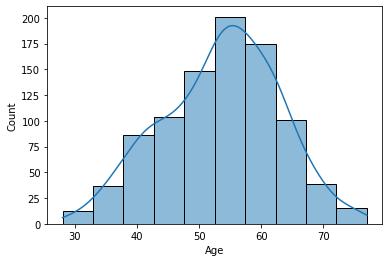

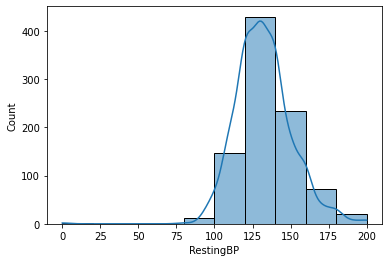

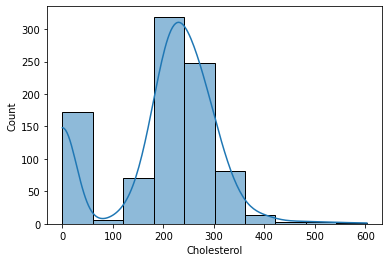

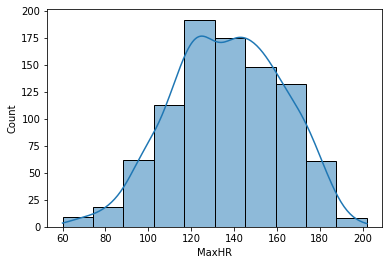

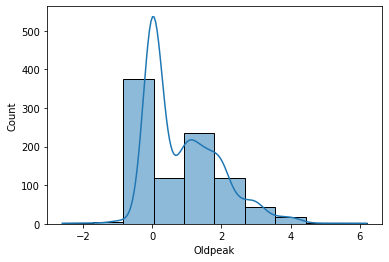

In [10]:
for i in num_cols:
  sns.histplot(x = df[i], data = df, kde=True, bins=10)
  plt.show()


- Giá trị 0 nằm trong 2 biến RestingBP và Cholesterol được xem là giá trị nhiễu.

- Thay giá trị 0 trong 2 biến này bằng median.


In [11]:
df['Cholesterol'].replace(0, df['Cholesterol'].median(), inplace = True)
df['RestingBP'].replace(0, df['RestingBP'].median(), inplace = True)

Dùng biểu đồ boxplot để kiểm tra outliers của biến liên tục.

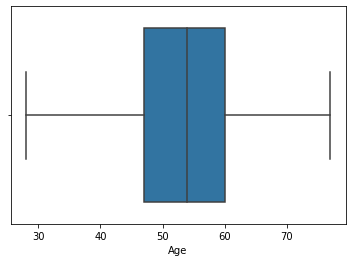

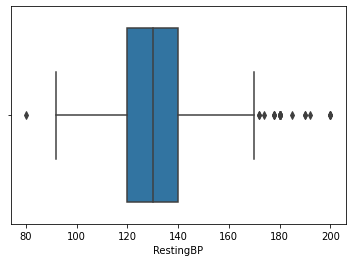

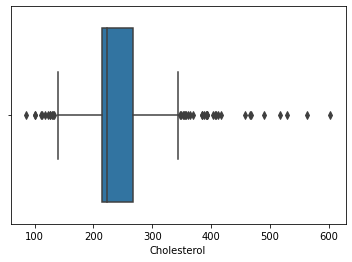

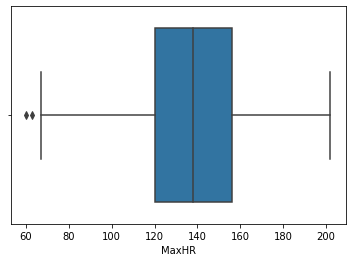

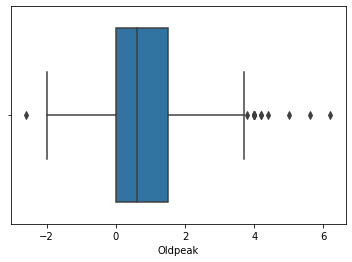

In [12]:
for i in num_cols:
  sns.boxplot(x = df[i], data = df)
  plt.show()


- Outliers nằm ở các biến RestingBP, Cholesterol, MaxHR và Oldpeak.

Dùng biểu đồ heatmap để kiểm tra mối tương quan giữa các biến liên tục.

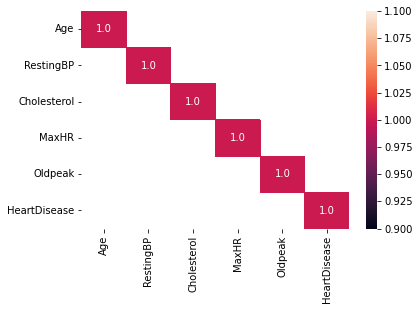

In [13]:
num = df.select_dtypes(include=['int64', 'float64'])
num_corr = num.corr()

sns.heatmap(num_corr[num_corr > 0.9], annot=True, fmt='.1f')
plt.show()

- Không có mối tương quan cao giữa các biến với nhau nên không cần loại bỏ biến nào.

Dùng biểu đồ barchart để xem phân phối của biến phân loại .

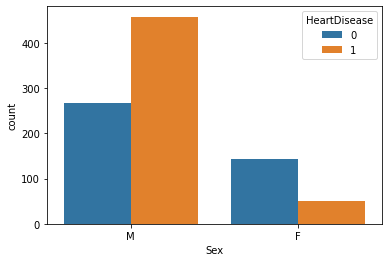

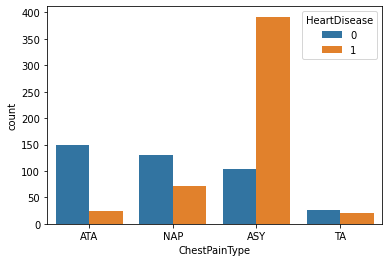

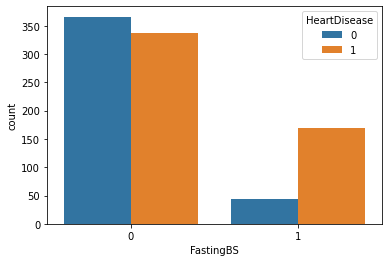

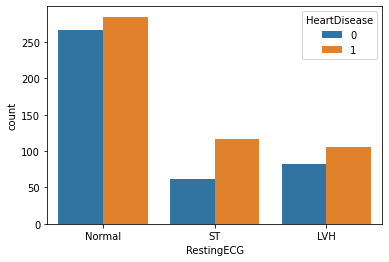

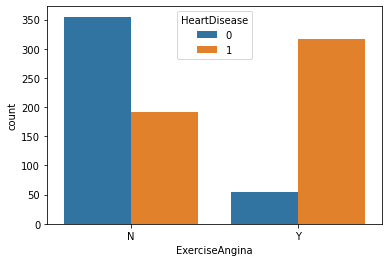

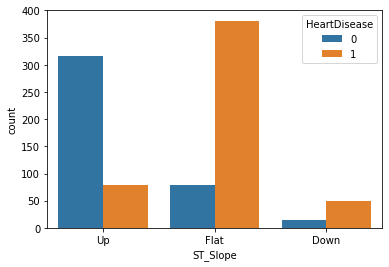

In [14]:
for i in cat_cols:
  sns.countplot(x = df[i], hue="HeartDisease", data = df)
  plt.show()

- Tỷ lệ bình thường/suy tim có sự khác biệt khá cáo tại các nhãn trong các biến này.

## **P3: Chọn độ đo**

Kiểm tra phân phối của biến mục tiêu (HeartDisease).

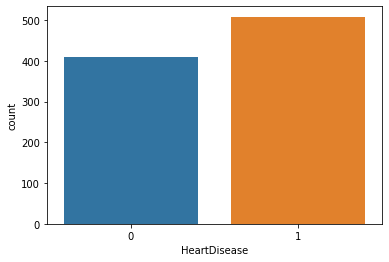

In [15]:
sns.countplot(x = "HeartDisease", data = df)
plt.show()

- Các nhãn trong biến mục tiêu không bị chênh lệch quá nhiều cho thấy dữ liệu chỉ bị mất cân bằng nhẹ, không đáng kể.

- Có 2 trường hợp quan trọng:
  - Dương tính giả (FP): Những người bình thường nhưng dự đoán ra suy tim.
  - Âm tính giả (FN): Những người suy tim nhưng dự đoán ra bình thường.

- Đây đều là 2 người hợp nghiêm trọng nên tôi sẽ chọn độ đo F1 score cho bài toán này.

## **P4: Chia train - test**

Áp dụng phương pháp lấy mẫu phân tầng giúp cân bằng tỷ lệ bình thường/suy tim trên cả train và test.

In [16]:
df_train, df_test = train_test_split(df, test_size = 0.3, stratify = df['HeartDisease'], random_state = 1)
X_train = df_train.copy()
y_train = X_train.pop("HeartDisease")

X_test = df_test.copy()
y_test = X_test.pop("HeartDisease")

Áp dụng phương pháp cross validation với k =5 lên tập train để chọn siêu tham số.

Trong đó 4 phần để train và 1 phần để val. 

![](https://drive.google.com/uc?id=1vrnXNYcja7HAKOEygjuKidT3KpFn2bxw)


## **P5: Train model**

Pipeline xử lý cho biến phân loại.

Encode biến phân loại theo phương pháp one hot encoding.

![](https://drive.google.com/uc?id=1ziL--QeMH6LT94S9z2NKzJ6-6TUKCblf)



In [17]:
cat_pl = Pipeline(
    steps = [
           ('onehot', OneHotEncoder())
    ]
)

Pipeline xử lý cho biến liên tục.

Scale biến liên tục theo phương pháp MinMax scaler.

![](https://drive.google.com/uc?id=1LvSdwR4xJKGoi5WAmD61Lu_tGS9czf0u)

In [18]:
num_pl = Pipeline(
    steps = [
           ('scaler', MinMaxScaler())
    ]
)

Tạo pipeline tiền xử lý dữ liệu hoàn chỉnh.

In [19]:
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', cat_pl, cat_cols),
        ('num', num_pl, num_cols)
    ]
)

**Thuật toán Random Forest**

- Với tập D, cần train các cây 1 cách độc lập.

- Với cây thứ i: lấy mẫu có trùng lặp từ mẫu ban đầu (Di = D).

- Phát triển cây thứ i bằng tập Di.

- Tại mỗi đỉnh:

  - Chọn ngẫu nhiên 1 tập nhỏ các thuộc tính S.
  -	Phát triển các nhánh con dựa trên tập S.

- Cho cây phát triển hết cỡ, không cắt tỉa.

Tạo pipeline train mô hình Random Forest.

In [20]:
rf_pl = Pipeline(
    steps = [
            ("preprocessor", preprocessor), 
            ("rf", RandomForestClassifier(random_state = 1))
    ]
)

Train mô hình Random Forest với bộ siêu tham số:

- max_features = 2, 3, 4
- n_extimators = 50, 100, 300

In [21]:
rf_param_grid = {
    'rf__max_features': [2, 3, 4],
    'rf__n_estimators': [50, 100, 300]
}

In [22]:
rf_model = GridSearchCV(
    estimator = rf_pl,
    param_grid = rf_param_grid,
    scoring = 'f1',
    cv = 5,
    verbose = 3
)

In [23]:
rf_model.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END rf__max_features=2, rf__n_estimators=50;, score=0.883 total time=   0.1s
[CV 2/5] END rf__max_features=2, rf__n_estimators=50;, score=0.890 total time=   0.1s
[CV 3/5] END rf__max_features=2, rf__n_estimators=50;, score=0.875 total time=   0.1s
[CV 4/5] END rf__max_features=2, rf__n_estimators=50;, score=0.892 total time=   0.1s
[CV 5/5] END rf__max_features=2, rf__n_estimators=50;, score=0.890 total time=   0.1s
[CV 1/5] END rf__max_features=2, rf__n_estimators=100;, score=0.892 total time=   0.2s
[CV 2/5] END rf__max_features=2, rf__n_estimators=100;, score=0.898 total time=   0.3s
[CV 3/5] END rf__max_features=2, rf__n_estimators=100;, score=0.892 total time=   0.3s
[CV 4/5] END rf__max_features=2, rf__n_estimators=100;, score=0.900 total time=   0.2s
[CV 5/5] END rf__max_features=2, rf__n_estimators=100;, score=0.890 total time=   0.2s
[CV 1/5] END rf__max_features=2, rf__n_estimators=300;, score=0.884 total t

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex',
                                                                          'ChestPainType',
                                                                          'FastingBS',
                                                                          'RestingECG',
                                                                          'ExerciseAngina',
                                                                          'ST_Slope']),
                                                                        ('num',
                            

In [24]:
rf_model.best_params_

{'rf__max_features': 2, 'rf__n_estimators': 100}

In [25]:
rf_model.best_score_

0.8944307852722725

Đánh giá mô hình Random Forest.

In [26]:
y_pred = rf_model.predict(X_test)

print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('\n')
print('Classification Report:\n', classification_report(y_test, y_pred))

Confusion Matrix:
 [[ 95  28]
 [ 12 141]]


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.77      0.83       123
           1       0.83      0.92      0.88       153

    accuracy                           0.86       276
   macro avg       0.86      0.85      0.85       276
weighted avg       0.86      0.86      0.85       276



- F1 = 0.88 cho thấy mô hình Random Forest dự đoán khá tốt.

**Thuật toán Logistic Regression**

- Được tiếp nối từ Linear Regression.

![](https://drive.google.com/uc?id=1tU0Rutv8t3tqlvnsXO1-sein1L0jJeOf)

- Hàm Sigmoid được sử dụng trong bài toán phân loại nhị phân.

![](https://drive.google.com/uc?id=18qPCty6pnwvXLEvyBLljlfX2vUirZwmk)

- Đầu ra của hàm Linear regression có dạng liên tục nên cần đưa vào hàm Sigmoid để tìm ra phân phối xác suất.

![](https://drive.google.com/uc?id=1PnicRlEiYM5jSYy2Ng5yweY9qdTZBFDV)

- Kết quả sẽ có giá trị từ 0 -> 1

  - Giá trị từ 0 -> 0.5 sẽ chuyển thành 0
  - Giá trị từ 0.5 -> 1 sẽ chuyển thành 1

![](https://drive.google.com/uc?id=1iqgDmDfcBh0F2qROL_31D0phsHZ1gLil)

Tạo pipeline train mô hình Logistic Regression.

In [27]:
lr_pl = Pipeline(
    steps = [
            ("preprocessor", preprocessor), 
            ("lr", LogisticRegression(class_weight='balanced', random_state = 1))
    ]
)

Train mô hình Logistic Regression với bộ siêu tham số:

- penalty = L1, L2, elasticnet

In [28]:
lr_param_grid = {
    "lr__penalty" : ["l1", "l2", "elasticnet"]
}

In [29]:
lr_model = GridSearchCV(
    estimator = lr_pl,
    param_grid = lr_param_grid,
    scoring = 'f1',
    cv = 5,
    verbose = 3
)

In [30]:
lr_model.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ......................lr__penalty=l1;, score=nan total time=   0.1s
[CV 2/5] END ......................lr__penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ......................lr__penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ......................lr__penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ......................lr__penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END ....................lr__penalty=l2;, score=0.847 total time=   0.1s
[CV 2/5] END ....................lr__penalty=l2;, score=0.873 total time=   0.1s
[CV 3/5] END ....................lr__penalty=l2;, score=0.853 total time=   0.1s
[CV 4/5] END ....................lr__penalty=l2;, score=0.913 total time=   0.1s
[CV 5/5] END ....................lr__penalty=l2;, score=0.881 total time=   0.1s
[CV 1/5] END ..............lr__penalty=elasticnet;, score=nan total time=   0.0s
[CV 2/5] END ..............lr__penalty=elasticnet

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex',
                                                                          'ChestPainType',
                                                                          'FastingBS',
                                                                          'RestingECG',
                                                                          'ExerciseAngina',
                                                                          'ST_Slope']),
                                                                        ('num',
                            

In [31]:
lr_model.best_params_

{'lr__penalty': 'l2'}

In [32]:
lr_model.best_score_

0.873554174273709

Đánh giá mô hình Logistic Regression.

In [33]:
y_pred = lr_model.predict(X_test)

print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('\n')
print('Classification Report:\n', classification_report(y_test, y_pred))

Confusion Matrix:
 [[ 96  27]
 [ 19 134]]


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.81       123
           1       0.83      0.88      0.85       153

    accuracy                           0.83       276
   macro avg       0.83      0.83      0.83       276
weighted avg       0.83      0.83      0.83       276



F1 = 0.85 cho thấy mô hình Logistic Regression dự đoán tệ hơn mô hình Random Forest.

## **P6: Kết luận**

Trong project này, tôi đã thực hiện EDA để phân tích khám phá dữ liệu. Dựa trên kết quả EDA, tôi đã thực hiện tiền xử lý dữ liệu và train trên 2 mô hình là Random Forest và Logistic Regression. Kết quả sau khi đánh giá cho thấy Random Forest có thể dự đoán tốt người có nguy cơ suy tim với F1 = 0.88.

## **P7: Reference**

- <https://phamdinhkhanh.github.io/deepai-book/intro.html>

- <https://sebastianraschka.com/blog/2016/model-evaluation-selection-part3.html>